In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
threshold = 0.001
ma_window=4

In [3]:
print('Reading input file')
df=pd.read_csv('../data/all_activity_normal.csv') # Read the data

Reading input file


In [38]:
df.columns

Index(['idcampaign', 'idcampaign_master', 'idOffer', 'Offer_Name',
       'Finance_Product', 'idadvertiser', 'idadvertiser_master', 'idBusiness',
       'Channel', 'campaign_budget', 'Retail_Cost', 'COGS', 'Overage',
       'impressions', 'clicks', 'CVTs', 'qualified_calls', 'calls', 'emails',
       'qualified_web_events', 'Leads', 'Paid_On', 'Cycle_Started',
       'Cycle_Ended', 'MCID_Started', 'Cycle_Number', 'Advertiser_BC_ID',
       'Advertiser_BusinessCategory', 'Advertiser_BSC_ID',
       'Advertiser_BusinessSubCategory', 'TargetType', 'Radius_Target_Address',
       'Radius_Target_Miles', 'Cities_Targetd', 'DMAs_Targeted',
       'Population_Target', 'ratio', 'ratio_cat', 'cycle_duration'],
      dtype='object')

In [39]:
df.campaign_budget.isnull().sum()

0

In [4]:
df.drop(columns=['Unnamed: 0','Country', 'Currency', 'Advertiser_URL',
                'BC_ID','BusinessCategory', 'Primary_BSC_ID', 'Primary_BusinessSubCategory',
                'Secondary_BSC_Count','Secondary_BSC_IDs','Seconardy_BSCs','BusinessSpecialtyID',
                'CTL', 'CPL','CPC', 'CTR',
                'BusinessSpecialty'], axis=1, inplace=True)
df.reset_index(inplace=True,drop=True)


# Dealing with Offer, Finance Product, idOffer (There are only a few of them?)

missing_offer_ids=df[df.Offer_Name.isna()]['idadvertiser_master'].unique()

# Check to see if their are missing at the exact same locations:

df=df[~df.idadvertiser_master.isin(missing_offer_ids)]
df.reset_index(inplace=True,drop=True)

# Create a duration column. For missing values, one option is to replace with the average 
# campaign duration of a given advertiser--> Local!
# However we're not sure why the cycle is missing an end date. Is that churn?
df['Cycle_Started']=pd.to_datetime(df.Cycle_Started, format='%Y-%m-%d',  errors='ignore')
df['Cycle_Ended']=pd.to_datetime(df.Cycle_Ended, format='%Y-%m-%d',  errors='ignore')

my_index=df[df['Cycle_Ended'] < df['Cycle_Started']].index

temp=df.loc[my_index, 'Cycle_Ended']

df.loc[my_index, 'Cycle_Ended'] = df.loc[my_index, 'Cycle_Started']

df.loc[my_index, 'Cycle_Started']=temp


df.reset_index(inplace=True,drop=True)
df['cycle_duration']=pd.to_timedelta(df['Cycle_Ended']-df['Cycle_Started']).astype('timedelta64[D]')

df.reset_index(inplace=True,drop=True)

# Get rid of the campaigns with zero budget and those starting at the end of the year.
df=df[~(df.campaign_budget==0)]
df=df[~(df.campaign_budget < 1)]

df=df[~(df.Cycle_Started==pd.to_datetime('2018-12-31 00:00:00'))]

df.reset_index(inplace=True,drop=True)

ids=df[pd.isnull(df.Cycle_Started)]['idadvertiser_master'].unique()

df=df[~(df.idadvertiser_master.isin(ids))]

df.reset_index(inplace=True,drop=True)

duration_mode=df.cycle_duration.mode() # Mode is 30. Let's impute the duration with this

#my_index=df[pd.isnull(df.cycle_duration)].index
#df.loc[my_index, 'cycle_duration']=duration_mode

df['cycle_duration'].fillna(duration_mode[0], inplace=True)

# Now reconstruct the end dates
my_index=df[pd.isnull(df.Cycle_Ended)].index
df.loc[my_index, 'Cycle_Ended']=df.loc[my_index, 'Cycle_Started']+pd.to_timedelta(str(duration_mode[0])+'D')

In [22]:
df.reset_index(drop=True, inplace=True)
# Trim down the dataframe
temp=df[['idadvertiser_master','idadvertiser','Cycle_Started','Cycle_Ended','cycle_duration']]
# Find unique ids 
adv_ids=temp.idadvertiser_master.unique()

# Create additional columns
temp['delta']=0.0
temp['summation']=0.0

from sklearn.linear_model import LinearRegression
mdl=LinearRegression(n_jobs=4)



seasonal=[]
period=[]

def ma(array, window=1):  # Moving average
    return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])


# id_subset=np.random.choice(adv_ids, 10, replace=False)
# has_zeros=[]
# Loop over ids
# for idd in id_subset:
for idd in [41104]:    
    #print('Processing advertiser ID=', idd)
    subset = temp[temp.idadvertiser_master==idd]
    subset.sort_values(by=['idadvertiser_master','Cycle_Started'],inplace=True)
    subset.reset_index(drop=True, inplace=True)
    
    if subset.shape[0]<ma_window:
        f=open('../data/seasonal.txt', 'a+')
        f.write(str(0)+'\n' )
        f.close()

        f=open('../data/periods.txt', 'a+')
        f.write(str(0)+'\n' )
        f.close()
    else:
    
        # Separating start and end
        start = subset.Cycle_Started
        end = subset.Cycle_Ended

        end_shift = end
        end_shift[1:]=end[0:-1]

        delta = start-end_shift
        subset['delta']=0.0
        for i in range(0,subset.shape[0]):
            subset.loc[i,'delta']=delta.iloc[i].days

        subset.loc[0,'delta']=0

        #subset['delta']=delta
        subset['summation']=subset['cycle_duration']+subset['delta']

        # Create the time series

        time_series= np.ones((1,int(subset['summation'].sum())))
       # print(time_series)
        pivot = 0
        for i in range(0,subset.shape[0]):
            if subset.loc[i,'delta'] > 0:
                start_index=int(subset.loc[0:i,'summation'].sum() )
                end_index=start_index+int( subset.loc[i,'delta'] )
                time_series[0][start_index:end_index]=0
                #has_zeros.append(idd)
                pivot=i
        

        time_series=time_series-ma(time_series, window=ma_window) # Remove the trend

        # Next largest power of 2        
        nfft=1<<(time_series.shape[1]-1).bit_length()

        y=np.fft.fft(time_series, n=nfft)
        y=abs(y**2)
        y=(y-y.min())
        y=y/y.max()

        freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
        freq_ts=1/freq_ts
        freq_ts=freq_ts[1:]
        freq_ts=freq_ts.reshape(-1,1)
        #period_ts=freq_ts[::-1]
        #period_ts=period_ts.reshape(1,-1).T
        
        y=y[0][1:int(nfft/2)].reshape(1,-1).T

In [9]:
has_zeros

[126262,
 80274,
 80199,
 80199,
 80199,
 41104,
 41104,
 41104,
 41104,
 41104,
 41104,
 41104,
 41104]

In [14]:
time_series.shape

(1, 207)

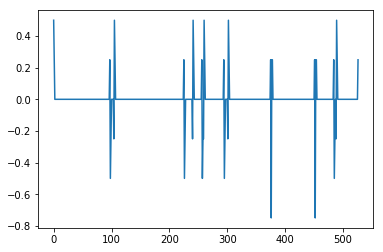

In [34]:
plt.plot(range(0,time_series.shape[1]), time_series[0])

In [25]:
freq_ts.shape
y.shape

(511, 1)

(0, 50)

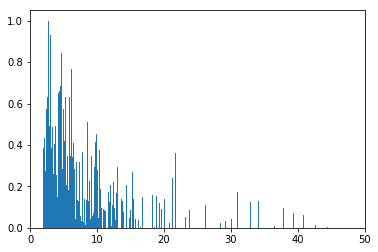

In [33]:
plt.bar(freq_ts.T[0], y.T[0], width=0.1)
plt.xlim(0,50)

In [35]:
np.argmax(y)

367

In [37]:
freq_ts[np.argmax(y)]

array([2.77717391])